# Implied volatility

The example '04_BlackScholesPricer_example.ipynb' introduces how the implementation of Black-Scholes pricing formula can be used in option pricing. To do this two parameters need to be provided for the model - the risk-free rate and the volatility. However, often the price of the option is not an unknown as the options are traded on the markets with known bids and asks. The problem is then to choose proper parameters that match the observed prices.

Since the risk-free rate is known with certainty, the only parameter that can be tweaked is the volatility. So instead of approximating it from historical data (see example '...') it can be chosen so that the observed and model prices match. This volatility is known as the _option implied volatility_. 

In [1]:
# Setup for the notebook
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

from quantform.pylib import QfDate
from quantform.pylib.equity.utils import parse_option_id, form_option_id
from quantform.pylib.equity.derivative import Option
from quantform.pylib.surface import ImpliedVolatilitySurface
from quantform.pylib.curve import ImpliedVolatilityCurve

ImpliedVolatilitySurface

quantform.pylib.surface.ImpliedVolatilitySurface.ImpliedVolatilitySurface

In [2]:
project_root = Path(os.path.abspath(""))

report_date = QfDate(2025, 8, 15)

# The used risk-free rate is the yield of a two year US Treasury quoted EOD 2025-08-15
risk_free_rate = 0.03755

# The value of the underlying is also quoted EOD 2025-08-15. Use a slightly smaller value so that the implied vol can be
# calculated. This is required as the bids and asks might not be up to date
underlying_value = 630  # Actual 643.44 USD

# Read the market data from a CSV file. The market data covers the option prices quoted EOD 2025-08-15 for all available SPY options
option_df = pd.read_csv(project_root / "example_data" / "SPY_Calls_2025-08-15.tsv", sep='\t')

# Function that creates an Option object from the given option price data. If the implied volatility cannot be calculated skips the option
def to_option(row: pd.Series) -> Option:
  # If the implied volatility is marked as zero in Yahoo Finance it most likely cannot be calculated
  if row["Implied Volatility"] == "0.00%":
    print(f"Invalid implied volatility with option {row["Contract Name"]}!")
    return
  try:
    return Option(row["Contract Name"], *parse_option_id(row["Contract Name"]), risk_free_rate=risk_free_rate, 
                  market_price=(row["Bid"] + row["Ask"]) / 2, underlying_value=underlying_value, report_date=report_date)
  except AssertionError as e:
     print(f"Not able to calculate the implied volatility for option {row["Contract Name"]}! ({e})")
         
# Note that calculating the implied volatilities for thousands of options is quite computationally expensive.
# However, as going forward the same underlying value and report date will be used, it is enough to do this just once
options = [to_option(row) for _, row in option_df.iterrows()]
options = [option for option in options if option is not None]

Invalid implied volatility with option SPY250818C00627000!
Invalid implied volatility with option SPY250818C00628000!
Invalid implied volatility with option SPY250818C00629000!
Invalid implied volatility with option SPY250818C00630000!
Invalid implied volatility with option SPY250829C00335000!
Invalid implied volatility with option SPY250829C00340000!
Invalid implied volatility with option SPY250829C00350000!
Invalid implied volatility with option SPY250829C00355000!
Invalid implied volatility with option SPY250829C00365000!
Invalid implied volatility with option SPY250829C00370000!
Invalid implied volatility with option SPY250829C00380000!
Invalid implied volatility with option SPY250829C00385000!
Invalid implied volatility with option SPY250829C00390000!
Invalid implied volatility with option SPY250829C00395000!
Invalid implied volatility with option SPY250829C00410000!
Invalid implied volatility with option SPY250829C00430000!
Invalid implied volatility with option SPY250829C0045500

SPY250818C00590000: Expected 2.8545344640300727 found 1.884503177972195
SPY250818C00624000: Expected 0.9207593755643901 found 1.0323185391394412
SPY250818C00632000: Expected 0.8877003847823826 found 0.7757496160691278
SPY250818C00680000: Expected 0.4454320897472137 found 0.39522029057790026
SPY250819C00600000: Expected 2.5772756400896877 found 1.1660450861815435
SPY250822C00470000: Expected 2.395588492825257 found 2.0849647589905627
SPY250829C00325000: Expected 2.4018081337108823 found 2.7502469043381295
SPY250829C00405000: Expected 2.333492184577515 found 2.00075030289331
SPY250905C00470000: Expected 1.4571301332221964 found 1.2140918983209827
SPY250905C00495000: Expected 1.1236247524259975 found 1.0628124129765864
SPY250912C00475000: Expected 1.2031455575554815 found 1.0313762387510608
SPY250912C00505000: Expected 0.7763802719351048 found 0.8760506650156302
SPY250912C00555000: Expected 0.7383698463870739 found 0.625492072388707
SPY250919C00210000: Expected 2.765444442929067 found 2.6

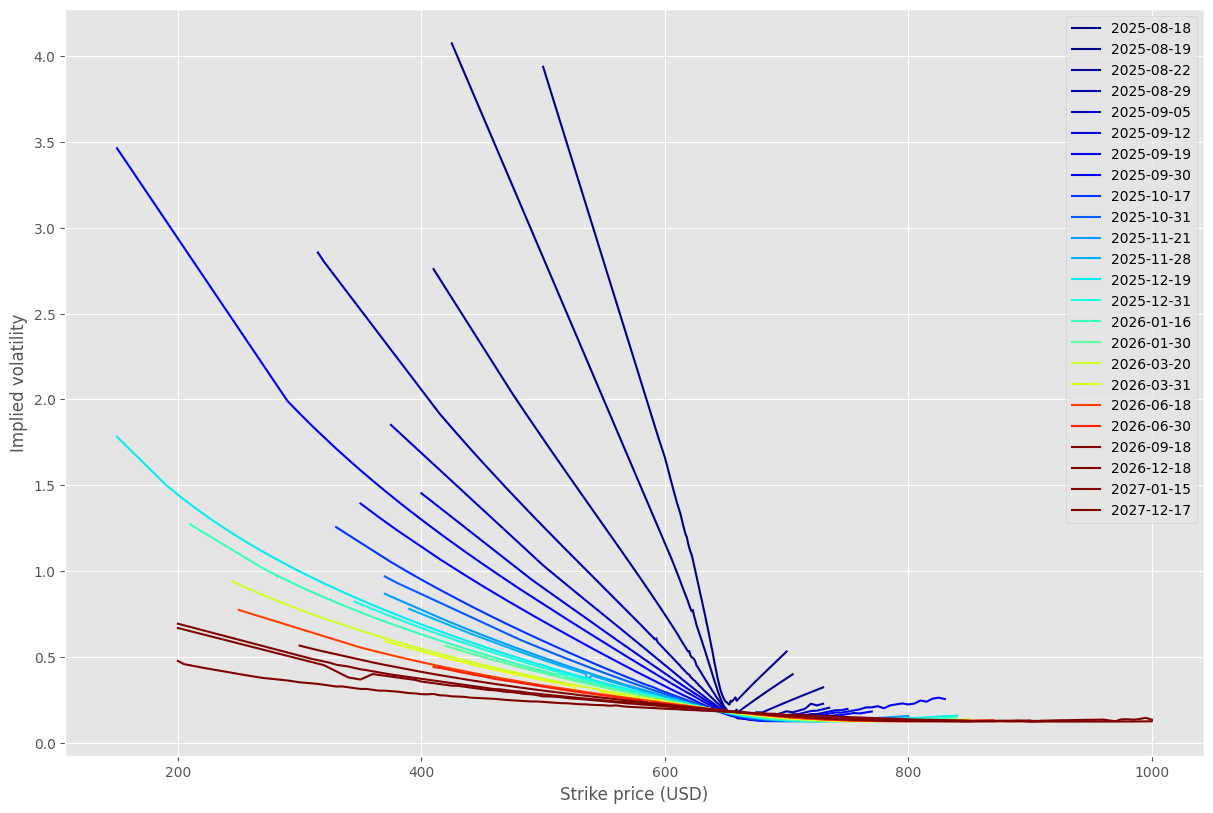

In [14]:
# Additional cleanup of the options might be required. So go over the options and drop the
# ones for which the calculated implied volatility differs significantly from it's neighbors
fig = plt.figure(figsize=(12, 8))

distinct_maturity_dates = list(set([option.maturity_date for option in options]))
distinct_maturity_dates.sort()

taus = np.array([report_date.timedelta(maturity_date) for maturity_date in distinct_maturity_dates])

plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(taus)))

valid_options = []

for maturity_date in distinct_maturity_dates:
  maturity_date_options = [option for option in options if option.maturity_date == maturity_date]
  valid_maturity_date_options = []
  
  for i, option in enumerate(maturity_date_options):
    
    if (i == 0) or (i == len(maturity_date_options) - 1):
      valid_maturity_date_options.append(option)
      continue
    
    expected_vol = (maturity_date_options[i - 1].pricer.volatility + maturity_date_options[i + 1].pricer.volatility) / 2
    
    if abs(expected_vol - option.pricer.volatility) < 0.03:
      valid_maturity_date_options.append(option)
    else:
      print(f"{option.contract_id}: Expected {expected_vol} found {option.pricer.volatility}")
      
  maturity_date_vols    = [option.pricer.volatility for option in valid_maturity_date_options]
  maturity_date_strikes = [option.strike for option in valid_maturity_date_options]
  
  plt.plot(maturity_date_strikes, maturity_date_vols, label=str(maturity_date))
  
  valid_options += valid_maturity_date_options

fig.tight_layout()
plt.legend()

plt.xlabel("Strike price (USD)")
plt.ylabel("Implied volatility")

plt.show()

options = valid_options

Note that from above we can see that the volatility curves look reasonable, but have differing amounts of options. Especially, the options maturing on very soon have only a few options. Thus, the options maturing on 2025-08-20, 2025-08-21 and 2025-09-26 will be removed.

In [4]:
options = valid_options

In [5]:
options = [option for option in options if option.maturity_date not in [QfDate(2025, 8, 20), QfDate(2025, 8, 21), QfDate(2025, 9, 26)]]
distinct_maturity_dates = list(set([option.maturity_date for option in options]))
distinct_maturity_dates.sort()

## ImpliedVolatilityCurve

The implied volatility was already calculated for a single option in the example '04_BlackScholesPricer_example.ipynb'. However, for options maturing on the same date a single value for volatility is rarely enough to explain the prices of all options. Thus, the implied volatility should be calculated for each option and interpolated between the available strikes. This can be done using the ImpliedVolatilityCurve object, which inherits most of it's functionality from the GenericCurve class introduced in example '02_curve_example.ipynb'.

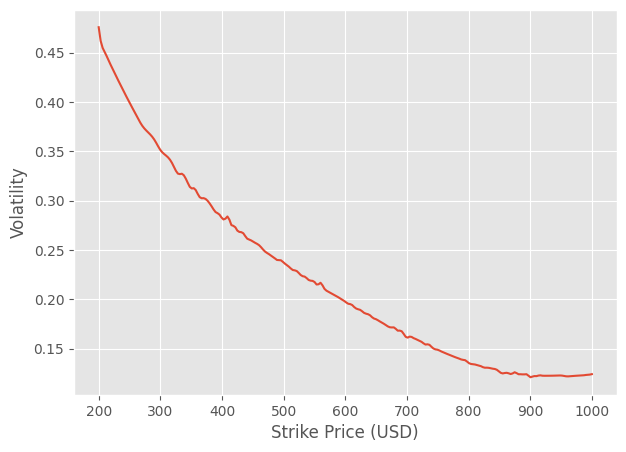

In [6]:
# Options with long time to maturity
curve_date = QfDate(2027, 12, 17)
curve_options = [option for option in options if option.maturity_date == curve_date]

curve = ImpliedVolatilityCurve(curve_options, underlying_value, report_date)
fig = curve.plot(250)

plt.xlabel("Strike Price (USD)")
plt.ylabel("Volatility")
plt.show()

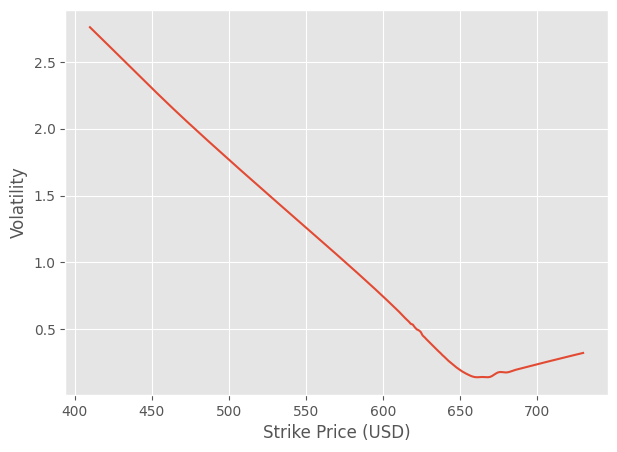

In [7]:
# Options with very short time to maturity
curve_date = QfDate(2025, 8, 22)
curve_options = [option for option in options if option.maturity_date == curve_date]

curve = ImpliedVolatilityCurve(curve_options, underlying_value, report_date)
fig = curve.plot(250)

plt.xlabel("Strike Price (USD)")
plt.ylabel("Volatility")
plt.show()

## Implied volatility as a function of maturity

As seen in the first figure, implied volatilities vary as a function of maturity date. This can also be illustrated as

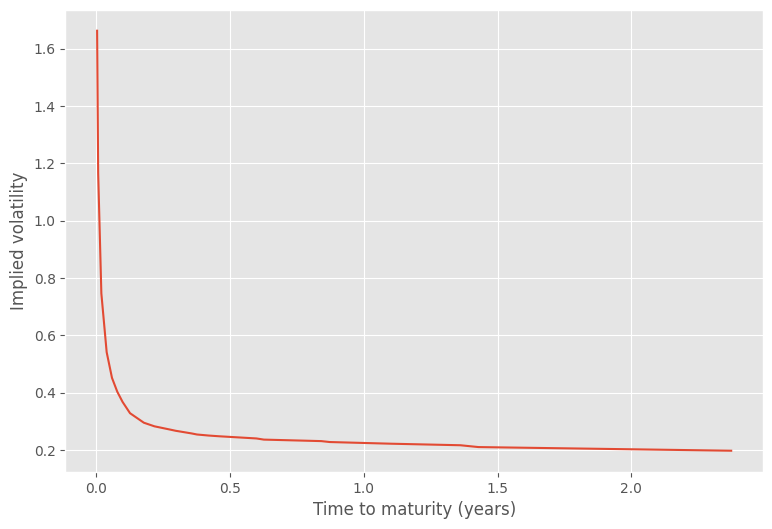

In [13]:
volatility_curves = {}

for maturity_date in distinct_maturity_dates:
  maturity_date_options = [option for option in options if option.maturity_date == maturity_date]
  maturity_date_curve   = ImpliedVolatilityCurve(maturity_date_options, underlying_value, report_date)
  volatility_curves[maturity_date] = maturity_date_curve
  
taus = [report_date.timedelta(maturity_date) for maturity_date in distinct_maturity_dates]
vols = [volatility_curves[maturity_date](600) for maturity_date in distinct_maturity_dates]

fig = plt.figure(figsize=(9, 6))

plt.plot(taus, vols)

plt.xlabel("Time to maturity (years)")
plt.ylabel("Implied volatility")

plt.show()

## ImpliedVolatilitySurface

Instead of calculating the implied volatilities for options with just a single maturity date, they can be calculated for all available options and interpolated for the rest to form an implied volatility surface.

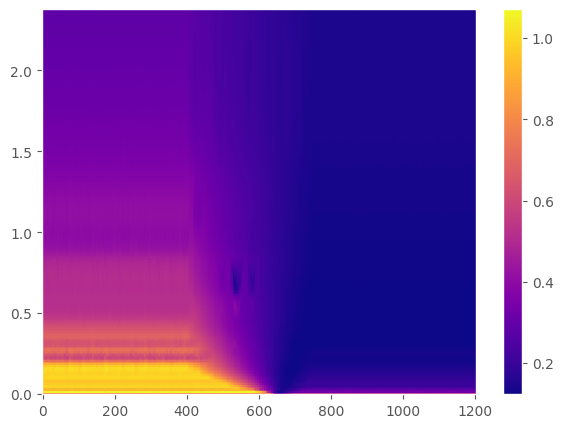

In [12]:
# Some options can have unreasonable volatilities due to poor price data. 
# Ignore these so that the surface is visible
valid_options = [option for option in options if (option.pricer.volatility > -1) and (option.pricer.volatility < 1)]

surf = ImpliedVolatilitySurface(valid_options, underlying_value, report_date, interp_range=(400, 750), extrap_range=[0, 1200], n_points=100)
fig = surf.plot((250, 250), cmap_name='plasma', plot_heatmap=True)

plt.show()

While somewhat hard to read the volatility surface does show a smile similar to that of the curve where the ITM options have higher implied volatility than ATM or OTM options. This effect is most apparent for the options maturing soon. 